In [1]:
!pip install --upgrade pip

In [2]:
!pip install tensorflow==2.15.0

In [3]:
!pip install transformers==4.38.2

In [4]:
!pip install pandas==1.5.3

In [5]:
!pip install numpy==1.26.4

In [6]:
!pip install scikit-learn==1.4.2

In [7]:
!pip install matplotlib==3.7.1

In [8]:

!pip install seaborn==0.12.2

In [9]:
!pip install gdown==5.1.0

In [10]:
!pip install wordcloud

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import random, os, gdown, re
from wordcloud import WordCloud
import gc

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Set paths for synthetic data on Google Drive
synthetic_folder = '/content/drive/MyDrive/synthetic_data'
if not os.path.exists(synthetic_folder):
    os.makedirs(synthetic_folder)
synthetic_positive_path = os.path.join(synthetic_folder, 'synthetic_positive.csv')
synthetic_negative_path = os.path.join(synthetic_folder, 'synthetic_negative.csv')

In [14]:
# TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU is ready")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("TPU not detected. Using CPU/GPU")
print("Distribution strategy:", strategy)


TPU not detected. Using CPU/GPU
Distribution strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7d0c741aaf10>


In [15]:
# Load real data from Google Drive
def load_real_data_from_drive():
    file_url = "https://drive.google.com/uc?id=1KRiUmF7XP32mHTFHxPz_p9si4YE0NMK0"
    output_path = "IMDB_Dataset.csv"
    print("Downloading dataset...")
    gdown.download(file_url, output_path, quiet=False)
    print("Loading dataset...")
    real_data = pd.read_csv(output_path)
    real_data['label'] = real_data['sentiment'].map({'positive': 1, 'negative': 0})
    print(f"Loaded dataset with {len(real_data)} entries.")
    return real_data[['review', 'label']]



In [16]:
# Load GPT-2 model and tokenizer (PyTorch)
def load_gpt2_model():
    model_name = "gpt2-medium"
    model = TFGPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    # Set padding_side to 'left' to avoid issues with decoder-only models.
    tokenizer.padding_side = "left"
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer

In [17]:
# Function for dynamic prompt generation
def generate_dynamic_prompt(sentiment):
    if sentiment == 'positive':
        adjectives = ["incredibly good", "amazing", "inspiring", "stunning", "fantastic"]
        reasons = [
            "the plot kept me on the edge of my seat from start to finish",
            "the acting was top-notch",
            "the visual effects were breathtaking",
            "the music perfectly complemented the movie's atmosphere",
            "every scene evoked strong emotions"
        ]
        prompt = f"Write an enthusiastic and detailed movie review. The movie was {random.choice(adjectives)} because {random.choice(reasons)}."
    elif sentiment == 'negative':
        adjectives = ["terrible", "disgusting", "disappointing", "dull", "uninteresting"]
        reasons = [
            "the plot was predictable and boring",
            "the actors failed to convey any emotion",
            "the visual effects looked unconvincing",
            "the music detracted from the movie experience",
            "every scene felt meaningless"
        ]
        prompt = f"Write a critical and detailed movie review. The movie was {random.choice(adjectives)} because {random.choice(reasons)}."
    else:
        raise ValueError("Sentiment must be 'positive' or 'negative'.")
    return prompt


In [18]:

# Function to clean the generated text by removing prompt remnants and undesired patterns
def clean_generated_text(text):
    patterns = [
        r"Write an enthusiastic and detailed movie review\.?",
        r"Write a critical and detailed movie review\.?",
        r"Write an? .* movie review\.?",
    ]
    for pattern in patterns:
        text = re.sub(pattern, "", text, flags=re.IGNORECASE)
    text = " ".join(text.split())
    return text

In [19]:
def generate_synthetic_data_batch(model, tokenizer, num_samples, sentiment, batch_size=32, save_path=None):
    synthetic_data = []
    prompts = []
    # Generate all prompts first
    for i in range(num_samples):
        prompt = generate_dynamic_prompt(sentiment).strip()
        if prompt:
            prompts.append(prompt)
        else:
            print(f"Empty prompt in iteration {i}. Skipping.")
    # Process prompts in batches
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        # Tokenize the batch with padding
        inputs = tokenizer(batch_prompts, return_tensors="tf", padding=True)
        # Calculate prompt lengths from the attention mask
        prompt_lens = tf.reduce_sum(inputs["attention_mask"], axis=1)  # shape: (batch_size,)
        max_prompt_len = int(tf.reduce_max(prompt_lens).numpy())
        # Generate outputs with additional 50 tokens beyond the longest prompt in the batch
        batch_outputs = model.generate(
            **inputs,
            max_length=max_prompt_len + 50,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            do_sample=True
        )
        # Decode outputs for each prompt in the batch
        for j in range(len(batch_prompts)):
            current_prompt_len = int(prompt_lens[j].numpy())
            output_ids = batch_outputs[j]
            if output_ids.shape[0] < current_prompt_len:
                print(f"Output length is shorter than prompt in batch index {j}: {batch_prompts[j]}")
                continue
            generated_ids = output_ids[current_prompt_len:]
            generated_text = tokenizer.decode(generated_ids.numpy().tolist(), skip_special_tokens=True)
            generated_text = clean_generated_text(generated_text)
            label = 1 if sentiment == 'positive' else 0
            synthetic_data.append({'review': generated_text, 'label': label})
    if save_path:
        df = pd.DataFrame(synthetic_data)
        df.to_csv(save_path, index=False)
        print(f"Synthetic {sentiment} data saved to {save_path}")
    return synthetic_data


In [20]:
def compute_perplexity(model, tokenizer, texts):
    if len(texts) == 0:
        print("No texts provided for perplexity calculation. Returning infinity.")
        return np.inf

    total_loss = 0.0
    # Loop through each text and accumulate the loss.
    for text in texts:
        # Ensure the text is a string.
        text = str(text)
        # Tokenize the text with truncation (max 100 tokens).
        inputs = tokenizer(text, return_tensors="tf", truncation=True, max_length=100)
        # Compute the model outputs with labels equal to input_ids.
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.numpy()  # Convert TF tensor to numpy scalar.
        total_loss += loss

    avg_loss = total_loss / len(texts)
    perplexity = np.exp(avg_loss)
    # Convert to Python float to avoid formatting errors.
    return float(perplexity)


In [21]:
def plot_word_map(texts):
    if not texts or not any(text.strip() for text in texts):
        print("No text available to generate word cloud.")
        return
    all_text = " ".join(texts)
    if not all_text.strip():
        print("No text available to generate word cloud.")
        return
    try:
        wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text)
    except ValueError as e:
        print(f"Word cloud generation error: {e}")
        return
    if len(wc.words_) == 0:
        print("Word cloud generation failed: no words found.")
        return
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Map for Data")
    plt.show()

In [22]:
# This function handles synthetic data generation separately.
def generate_and_save_synthetic_data():
    # Load GPT-2 model and tokenizer
    gpt2_model, gpt2_tokenizer = load_gpt2_model()

    # Generate synthetic positive reviews in batches
    print("Generating synthetic positive reviews...")
    synthetic_data_positive = generate_synthetic_data_batch(
        gpt2_model, gpt2_tokenizer, num_samples=5000, sentiment='positive', batch_size=32, save_path=synthetic_positive_path
    )

    # Generate synthetic negative reviews in batches
    print("Generating synthetic negative reviews...")
    synthetic_data_negative = generate_synthetic_data_batch(
        gpt2_model, gpt2_tokenizer, num_samples=5000, sentiment='negative', batch_size=32, save_path=synthetic_negative_path
    )

    synthetic_texts = [item['review'] for item in (synthetic_data_positive + synthetic_data_negative)]
    if len(synthetic_texts) > 0:
        perplexity = compute_perplexity(gpt2_model, gpt2_tokenizer, synthetic_texts)
        print(f"Perplexity of synthetic data: {perplexity:.2f}")
    else:
        print("No synthetic texts generated to compute perplexity.")
    if any(text.strip() for text in synthetic_texts):
        plot_word_map(synthetic_texts)
        plot_word_map(df_pos['review'].tolist())
        plot_word_map(df_neg['review'].tolist())
    else:
        print("No text available to generate word cloud.")

In [ ]:
# Prepare data with balancing and validation split
def prepare_data_for_training(real_data, synthetic_data, real_ratio):
    total_samples = len(real_data)
    real_count = int(real_ratio * total_samples)
    synthetic_count = total_samples - real_count
    print(f"Using {real_count} real samples and {synthetic_count} synthetic samples.")

    if real_count > len(real_data):
        real_count = len(real_data)
    if synthetic_count > len(synthetic_data):
        synthetic_count = len(synthetic_data)

    real_sample = real_data.sample(real_count, random_state=42) if real_count > 0 else pd.DataFrame()
    synthetic_sample = pd.DataFrame(synthetic_data).sample(synthetic_count, random_state=42) if synthetic_count > 0 else pd.DataFrame()

    # Drop rows with missing or empty 'review' and missing 'label'
    combined_data = pd.concat([real_sample, synthetic_sample], ignore_index=True)
    combined_data = combined_data.dropna(subset=['review', 'label'])
    combined_data = combined_data[combined_data['review'].str.strip() != '']

    # Balance classes
    pos_samples = combined_data[combined_data['label'] == 1]
    neg_samples = combined_data[combined_data['label'] == 0]
    min_samples = min(len(pos_samples), len(neg_samples))
    pos_balanced = resample(pos_samples, replace=False, n_samples=min_samples, random_state=42)
    neg_balanced = resample(neg_samples, replace=False, n_samples=min_samples, random_state=42)
    balanced_data = pd.concat([pos_balanced, neg_balanced]).sample(frac=1, random_state=42)

    X = balanced_data['review']
    y = balanced_data['label'].astype(int)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2 of total
    X_test = chunk2['review']
    y_test = chunk2['label']
    return X_train, X_val, X_test, y_train, y_val, y_test




In [ ]:
# Logistic Regression model
def logistic_regression_model(X_train, y_train):
    from sklearn.linear_model import LogisticRegression
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    return model, vectorizer



In [ ]:
# Preprocess text for LSTM
def preprocess_text_for_lstm(X_train, X_test, X_val, vocab_size=5000, max_length=100):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post', truncating='post')
    X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post', truncating='post')
    return X_train_pad, X_test_pad, X_val_pad, tokenizer


In [ ]:
# LSTM model
def lstm_model(vocab_size, max_length):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name, ratio):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name} at {ratio*100}% Real Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Evaluate model with additional metrics
def evaluate_model(model, X_test, y_test, model_type='logistic', model_name="", ratio=0):

    if model_type == 'bert':
        predictions = model.predict(X_test)
        y_pred = np.argmax(predictions.logits, axis=1)
        y_pred_proba = tf.nn.softmax(predictions.logits, axis=1)[:, 1].numpy()
    elif model_type == 'logistic':
        # For logistic regression, predict returns probability estimates.
        y_pred_proba = model.predict(X_test)
        y_pred = np.round(y_pred_proba)
    elif model_type == 'lstm':
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    plot_confusion_matrix(y_test, y_pred, model_name, ratio)

    return acc, prec, rec, f1, auc

In [ ]:
generate_and_save_synthetic_data()

In [ ]:
df = load_real_data_from_drive()
real_data = df.sample(n=5000, random_state=42)
remaining = df.drop(index=real_data.index)
chunk2 = remaining.sample(n=1000, random_state=42)

# Load synthetic data from Google Drive (assumes data was generated previously)
print("Loading synthetic data from Google Drive...")
synthetic_data_positive = pd.read_csv(synthetic_positive_path).to_dict('records')
synthetic_data_negative = pd.read_csv(synthetic_negative_path).to_dict('records')
synthetic_data = synthetic_data_positive + synthetic_data_negative

Downloading...
From: https://drive.google.com/uc?id=1KRiUmF7XP32mHTFHxPz_p9si4YE0NMK0
To: /content/IMDB_Dataset.csv
100%|██████████| 66.2M/66.2M [00:00<00:00, 89.6MB/s]


Loading dataset...
Loaded dataset with 50000 entries.
Loading synthetic data from Google Drive...


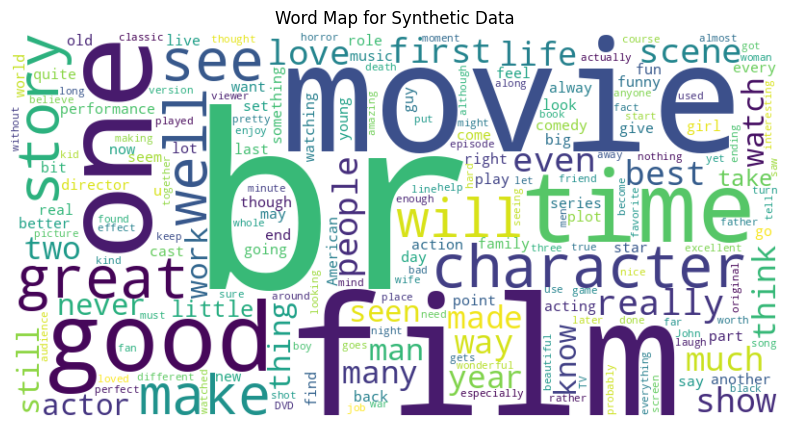

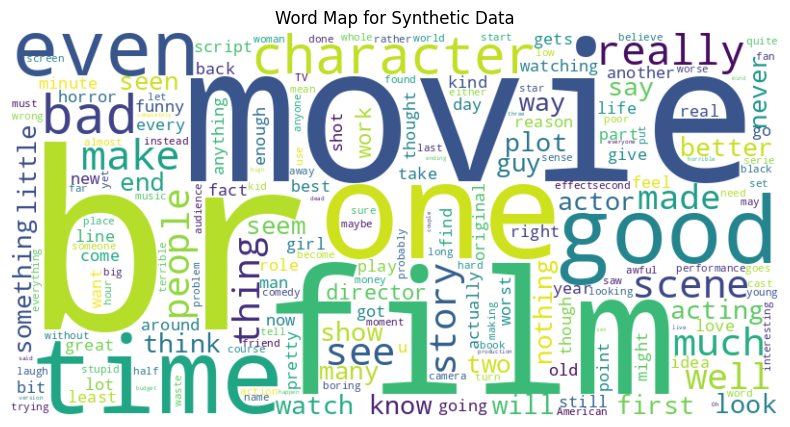

In [ ]:
chunk1_pos = real_data[real_data['label'] == 1].copy()
chunk1_neg = real_data[real_data['label'] == 0].copy()
chunk1_pos=chunk1_pos['review'].astype(str)
chunk1_neg=chunk1_neg['review'].astype(str)
plot_word_map(chunk1_pos.tolist())
plot_word_map(chunk1_neg.tolist())


=== Logistic Regression Experiments ===

--- Logistic Regression: 0% real data ---
Using 0 real samples and 5000 synthetic samples.
Accuracy: 0.687
Precision: 0.819
Recall: 0.512
F1 Score: 0.630
AUC-ROC: 0.695


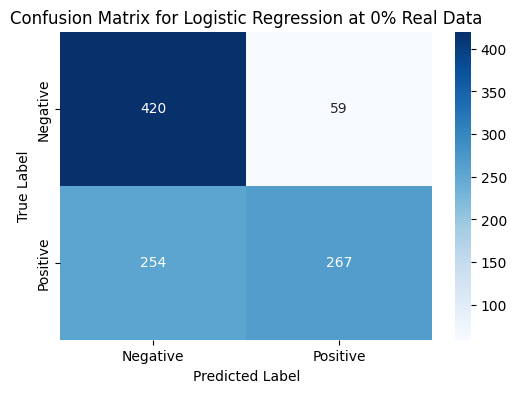


--- Logistic Regression: 25% real data ---
Using 1250 real samples and 3750 synthetic samples.
Accuracy: 0.794
Precision: 0.849
Recall: 0.735
F1 Score: 0.788
AUC-ROC: 0.797


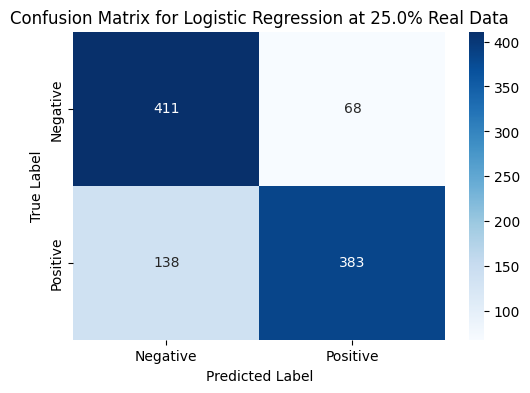


--- Logistic Regression: 50% real data ---
Using 2500 real samples and 2500 synthetic samples.
Accuracy: 0.815
Precision: 0.846
Recall: 0.789
F1 Score: 0.816
AUC-ROC: 0.816


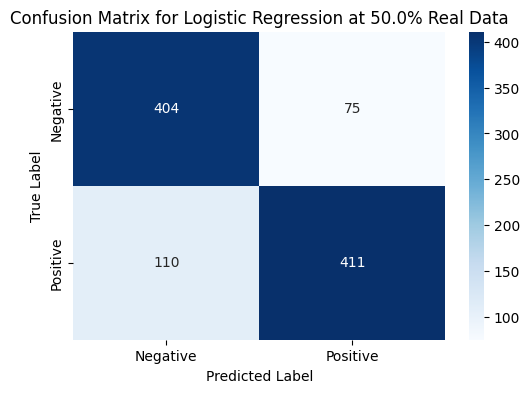


--- Logistic Regression: 75% real data ---
Using 3750 real samples and 1250 synthetic samples.
Accuracy: 0.839
Precision: 0.849
Recall: 0.841
F1 Score: 0.845
AUC-ROC: 0.839


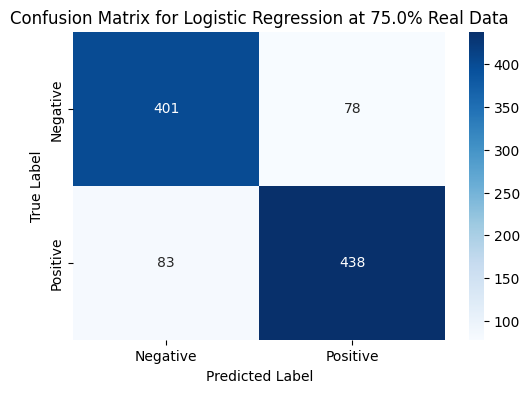


--- Logistic Regression: 100% real data ---
Using 5000 real samples and 0 synthetic samples.
Accuracy: 0.840
Precision: 0.845
Recall: 0.848
F1 Score: 0.847
AUC-ROC: 0.840


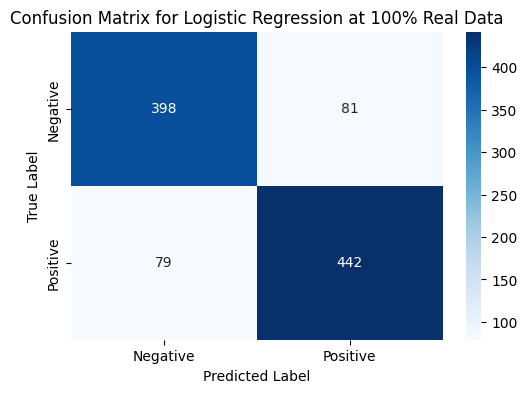

Logistic Regression Results:
{0: {'accuracy': 0.687, 'f1_score': 0.6304604486422668, 'auc': 0.6946513650078739}, 0.25: {'accuracy': 0.794, 'f1_score': 0.7880658436213992, 'auc': 0.7965811691824378}, 0.5: {'accuracy': 0.815, 'f1_score': 0.8162859980139027, 'auc': 0.816145680981251}, 0.75: {'accuracy': 0.839, 'f1_score': 0.8447444551591128, 'auc': 0.8389258652262591}, 1: {'accuracy': 0.84, 'f1_score': 0.8467432950191571, 'auc': 0.8396331128109986}}


In [ ]:
print("\n=== Logistic Regression Experiments ===")
logistic_results = {}
proportions = [0, 0.25, 0.5, 0.75, 1]

for ratio in proportions:
    print(f"\n--- Logistic Regression: {int(ratio*100)}% real data ---")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=ratio)
    model, vectorizer = logistic_regression_model(X_train, y_train)
    X_test_tfidf = vectorizer.transform(X_test)
    acc, prec, rec, f1, auc = evaluate_model(
        model, X_test_tfidf, y_test,
        model_type='logistic',
        model_name='Logistic Regression',
        ratio=ratio
    )
    logistic_results[ratio] = {"accuracy": acc, "f1_score": f1, "auc": auc}

print("Logistic Regression Results:")
print(logistic_results)


=== LSTM Experiments ===

--- LSTM: 0% real data ---
Using 0 real samples and 5000 synthetic samples.
Epoch 1/10
92/92 [==============================] - 19s 142ms/step - loss: 0.3836 - accuracy: 0.8641 - val_loss: 0.1873 - val_accuracy: 0.9199
Epoch 2/10
92/92 [==============================] - 12s 134ms/step - loss: 0.1334 - accuracy: 0.9504 - val_loss: 0.1435 - val_accuracy: 0.9405
Epoch 3/10
92/92 [==============================] - 12s 132ms/step - loss: 0.0736 - accuracy: 0.9774 - val_loss: 0.1776 - val_accuracy: 0.9343
Epoch 4/10
92/92 [==============================] - 12s 131ms/step - loss: 0.0424 - accuracy: 0.9853 - val_loss: 0.1507 - val_accuracy: 0.9456
Epoch 5/10
32/32 [==============================] - 1s 19ms/step
Accuracy: 0.589
Precision: 0.664
Recall: 0.428
F1 Score: 0.520
AUC-ROC: 0.659


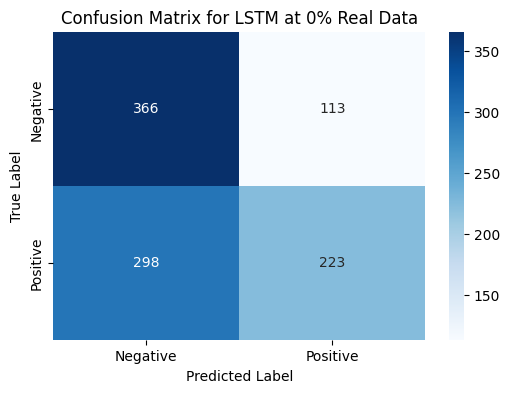


--- LSTM: 25.0% real data ---
Using 1250 real samples and 3750 synthetic samples.
Epoch 1/10
93/93 [==============================] - 18s 135ms/step - loss: 0.4802 - accuracy: 0.7529 - val_loss: 0.2981 - val_accuracy: 0.8503
Epoch 2/10
93/93 [==============================] - 12s 129ms/step - loss: 0.2445 - accuracy: 0.8931 - val_loss: 0.2513 - val_accuracy: 0.8819
Epoch 3/10
93/93 [==============================] - 12s 131ms/step - loss: 0.1385 - accuracy: 0.9477 - val_loss: 0.2648 - val_accuracy: 0.8758
Epoch 4/10
93/93 [==============================] - 12s 130ms/step - loss: 0.0815 - accuracy: 0.9715 - val_loss: 0.2828 - val_accuracy: 0.8829
Epoch 5/10
32/32 [==============================] - 1s 19ms/step
Accuracy: 0.686
Precision: 0.725
Recall: 0.641
F1 Score: 0.680
AUC-ROC: 0.752


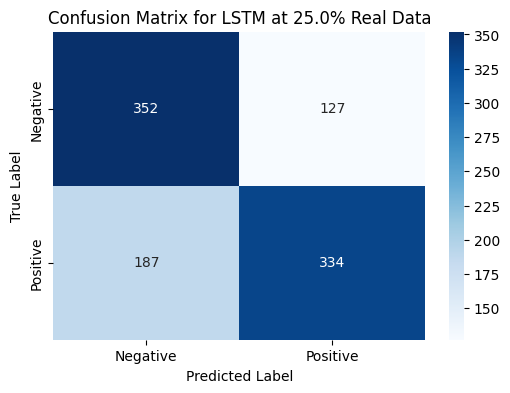


--- LSTM: 50.0% real data ---
Using 2500 real samples and 2500 synthetic samples.
Epoch 1/10
93/93 [==============================] - 19s 136ms/step - loss: 0.5574 - accuracy: 0.6969 - val_loss: 0.4196 - val_accuracy: 0.7988
Epoch 2/10
93/93 [==============================] - 12s 133ms/step - loss: 0.3191 - accuracy: 0.8614 - val_loss: 0.4185 - val_accuracy: 0.8130
Epoch 3/10
93/93 [==============================] - 12s 131ms/step - loss: 0.1921 - accuracy: 0.9234 - val_loss: 0.4198 - val_accuracy: 0.8079
Epoch 4/10
93/93 [==============================] - 12s 130ms/step - loss: 0.1063 - accuracy: 0.9603 - val_loss: 0.5526 - val_accuracy: 0.7967
Epoch 5/10
32/32 [==============================] - 1s 20ms/step
Accuracy: 0.725
Precision: 0.767
Recall: 0.678
F1 Score: 0.720
AUC-ROC: 0.787


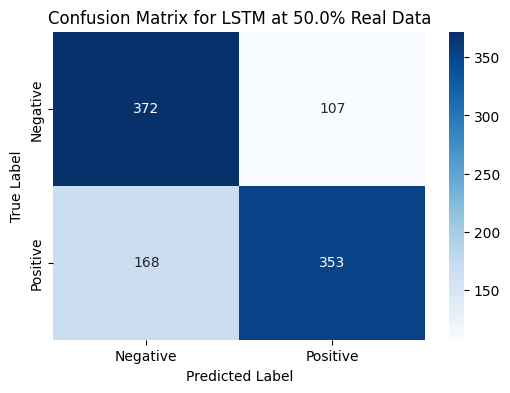


--- LSTM: 75.0% real data ---
Using 3750 real samples and 1250 synthetic samples.
Epoch 1/10
94/94 [==============================] - 18s 137ms/step - loss: 0.6305 - accuracy: 0.6213 - val_loss: 0.5130 - val_accuracy: 0.7321
Epoch 2/10
94/94 [==============================] - 12s 131ms/step - loss: 0.3668 - accuracy: 0.8510 - val_loss: 0.4134 - val_accuracy: 0.8066
Epoch 3/10
94/94 [==============================] - 12s 130ms/step - loss: 0.2054 - accuracy: 0.9211 - val_loss: 0.5014 - val_accuracy: 0.8077
Epoch 4/10
94/94 [==============================] - 12s 132ms/step - loss: 0.1305 - accuracy: 0.9537 - val_loss: 0.5046 - val_accuracy: 0.8016
Epoch 5/10
32/32 [==============================] - 1s 20ms/step
Accuracy: 0.763
Precision: 0.770
Recall: 0.777
F1 Score: 0.774
AUC-ROC: 0.830


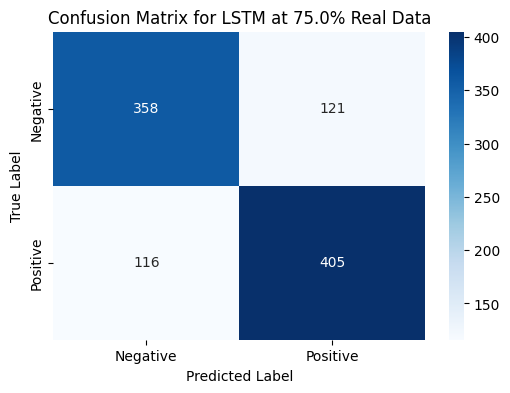


--- LSTM: 100% real data ---
Using 5000 real samples and 0 synthetic samples.
Epoch 1/10
93/93 [==============================] - 14s 114ms/step - loss: 0.6859 - accuracy: 0.5504 - val_loss: 0.6507 - val_accuracy: 0.5821
Epoch 2/10
93/93 [==============================] - 10s 109ms/step - loss: 0.5565 - accuracy: 0.7359 - val_loss: 0.5503 - val_accuracy: 0.7170
Epoch 3/10
93/93 [==============================] - 10s 109ms/step - loss: 0.3412 - accuracy: 0.8569 - val_loss: 0.5091 - val_accuracy: 0.7513
Epoch 4/10
93/93 [==============================] - 10s 110ms/step - loss: 0.2000 - accuracy: 0.9341 - val_loss: 0.5650 - val_accuracy: 0.7754
Epoch 5/10
93/93 [==============================] - 10s 109ms/step - loss: 0.1276 - accuracy: 0.9553 - val_loss: 0.8110 - val_accuracy: 0.7603
Epoch 6/10
32/32 [==============================] - 1s 20ms/step
Accuracy: 0.747
Precision: 0.713
Recall: 0.862
F1 Score: 0.780
AUC-ROC: 0.826


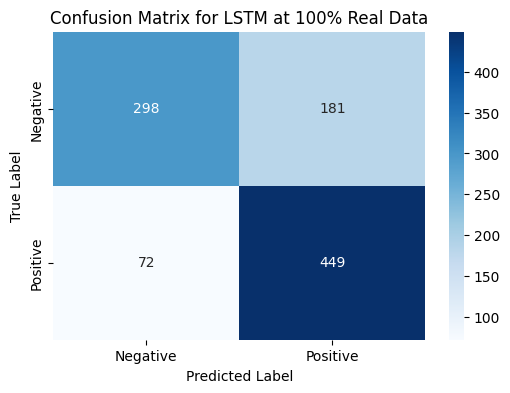

LSTM Results:
{0: {'accuracy': 0.589, 'f1_score': 0.5204200700116686, 'auc': 0.6594873356601044}, 0.25: {'accuracy': 0.686, 'f1_score': 0.6802443991853361, 'auc': 0.75220689295918}, 0.5: {'accuracy': 0.725, 'f1_score': 0.7196738022426096, 'auc': 0.787497144963716}, 0.75: {'accuracy': 0.763, 'f1_score': 0.7736389684813754, 'auc': 0.8296635264606766}, 1: {'accuracy': 0.747, 'f1_score': 0.7801911381407471, 'auc': 0.8257005357450543}}


In [ ]:
print("\n=== LSTM Experiments ===")
lstm_results = {}

for ratio in proportions:
    print(f"\n--- LSTM: {ratio*100}% real data ---")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=ratio)
    X_train_pad, X_test_pad, X_val_pad, lstm_tokenizer = preprocess_text_for_lstm(X_train, X_test, X_val)
    with strategy.scope():
        lstm = lstm_model(vocab_size=5000, max_length=100)
    lstm.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_pad, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    acc, prec, rec, f1, auc = evaluate_model(
        lstm, X_test_pad, y_test,
        model_type='lstm',
        model_name='LSTM',
        ratio=ratio
    )
    lstm_results[ratio] = {"accuracy": acc, "f1_score": f1, "auc": auc}

print("LSTM Results:")
print(lstm_results)

In [ ]:
def get_new_bert_model_and_tokenizer():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    return tokenizer, model

# Helper to prepare tf.data.Dataset
def prepare_dataset(tokenizer, X, y, batch_size=32, max_length=100):
    encodings = tokenizer(X.tolist(), truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), y))
    return dataset.shuffle(1000).batch(batch_size)




--- BERT: 0% real data ---
Using 0 real samples and 5000 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
92/92 [==============================] - 262s 3s/step - loss: 0.2820 - accuracy: 0.8710 - val_loss: 0.1105 - val_accuracy: 0.9671
Epoch 2/10
92/92 [==============================] - 224s 2s/step - loss: 0.0716 - accuracy: 0.9754 - val_loss: 0.1037 - val_accuracy: 0.9610
Epoch 3/10
92/92 [==============================] - 221s 2s/step - loss: 0.0465 - accuracy: 0.9819 - val_loss: 0.0984 - val_accuracy: 0.9630
Epoch 4/10
92/92 [==============================] - 221s 2s/step - loss: 0.0186 - accuracy: 0.9945 - val_loss: 0.1087 - val_accuracy: 0.9754
Epoch 5/10
32/32 [==============================] - 30s 814ms/step
Accuracy: 0.742
Precision: 0.771
Recall: 0.718
F1 Score: 0.744
AUC-ROC: 0.824


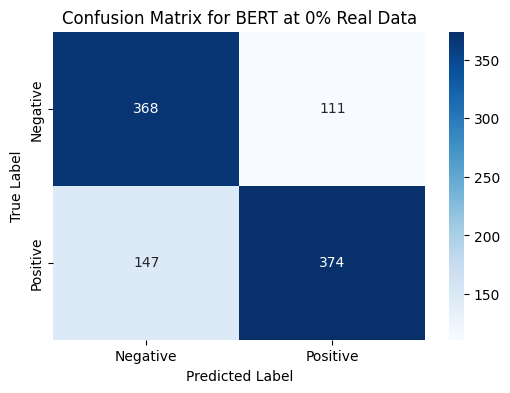

(0.742,
 0.7711340206185567,
 0.7178502879078695,
 0.7435387673956262,
 0.8243942314242323)

In [ ]:
print("\n--- BERT: 0% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.0)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=0)



--- BERT: 25% real data ---
Using 1250 real samples and 3750 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
93/93 [==============================] - 317s 3s/step - loss: 0.3821 - accuracy: 0.8255 - val_loss: 0.2180 - val_accuracy: 0.9145
Epoch 2/10
93/93 [==============================] - 285s 3s/step - loss: 0.1623 - accuracy: 0.9416 - val_loss: 0.1883 - val_accuracy: 0.9196
Epoch 3/10
93/93 [==============================] - 287s 3s/step - loss: 0.0776 - accuracy: 0.9749 - val_loss: 0.2015 - val_accuracy: 0.9216
Epoch 4/10
32/32 [==============================] - 30s 820ms/step
Accuracy: 0.808
Precision: 0.849
Recall: 0.768
F1 Score: 0.806
AUC-ROC: 0.893


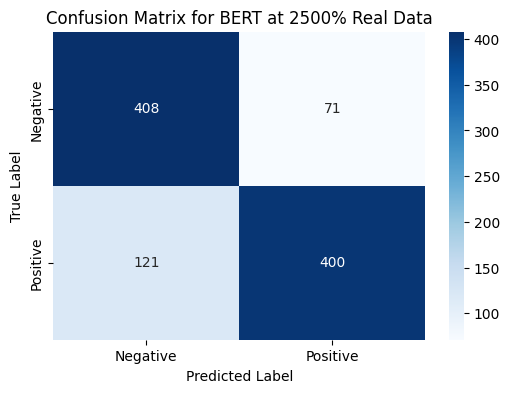

(0.808,
 0.8492569002123143,
 0.7677543186180422,
 0.8064516129032258,
 0.8932436818547919)

In [ ]:
print("\n--- BERT: 25% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.25)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=25)



--- BERT: 50% real data ---
Using 2500 real samples and 2500 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
93/93 [==============================] - 318s 3s/step - loss: 0.4410 - accuracy: 0.7895 - val_loss: 0.3112 - val_accuracy: 0.8648
Epoch 2/10
93/93 [==============================] - 280s 3s/step - loss: 0.2057 - accuracy: 0.9214 - val_loss: 0.2679 - val_accuracy: 0.8831
Epoch 3/10
93/93 [==============================] - 285s 3s/step - loss: 0.1179 - accuracy: 0.9617 - val_loss: 0.4013 - val_accuracy: 0.8628
Epoch 4/10
32/32 [==============================] - 31s 839ms/step
Accuracy: 0.820
Precision: 0.853
Recall: 0.791
F1 Score: 0.821
AUC-ROC: 0.906


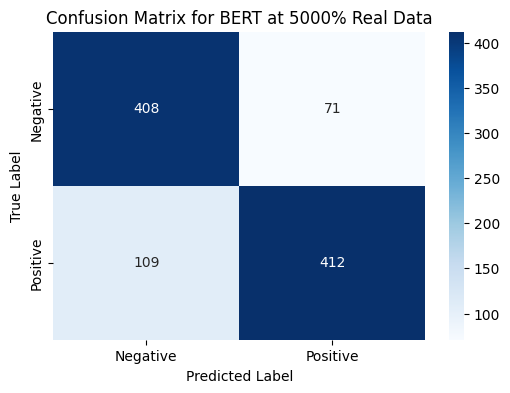

(0.82,
 0.8530020703933747,
 0.7907869481765835,
 0.8207171314741036,
 0.9057617637512572)

In [ ]:
print("\n--- BERT: 50% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.5)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=50)



--- BERT: 75% real data ---
Using 3750 real samples and 1250 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
94/94 [==============================] - 318s 3s/step - loss: 0.4856 - accuracy: 0.7623 - val_loss: 0.3410 - val_accuracy: 0.8590
Epoch 2/10
94/94 [==============================] - 284s 3s/step - loss: 0.2889 - accuracy: 0.8828 - val_loss: 0.2819 - val_accuracy: 0.8721
Epoch 3/10
94/94 [==============================] - 284s 3s/step - loss: 0.1567 - accuracy: 0.9490 - val_loss: 0.3177 - val_accuracy: 0.8781
Epoch 4/10
32/32 [==============================] - 30s 813ms/step
Accuracy: 0.832
Precision: 0.813
Recall: 0.879
F1 Score: 0.845
AUC-ROC: 0.914


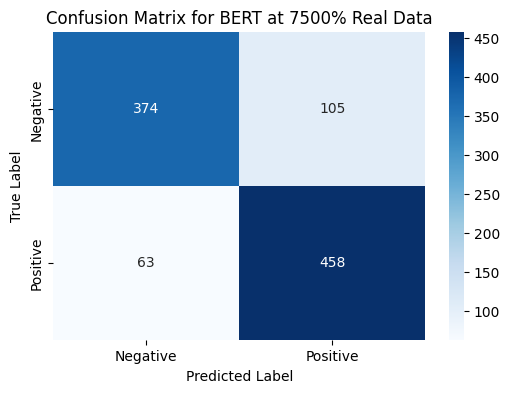

(0.832,
 0.8134991119005328,
 0.8790786948176583,
 0.8450184501845018,
 0.9143288761375066)

In [ ]:
print("\n--- BERT: 75% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=0.75)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=75)



--- BERT: 100% real data ---
Using 5000 real samples and 0 synthetic samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
93/93 [==============================] - 320s 3s/step - loss: 0.5452 - accuracy: 0.7080 - val_loss: 0.4293 - val_accuracy: 0.8077
Epoch 2/10
93/93 [==============================] - 289s 3s/step - loss: 0.3126 - accuracy: 0.8737 - val_loss: 0.3709 - val_accuracy: 0.8399
Epoch 3/10
93/93 [==============================] - 287s 3s/step - loss: 0.1777 - accuracy: 0.9382 - val_loss: 0.4164 - val_accuracy: 0.8389
Epoch 4/10
32/32 [==============================] - 30s 803ms/step
Accuracy: 0.842
Precision: 0.813
Recall: 0.904
F1 Score: 0.856
AUC-ROC: 0.922


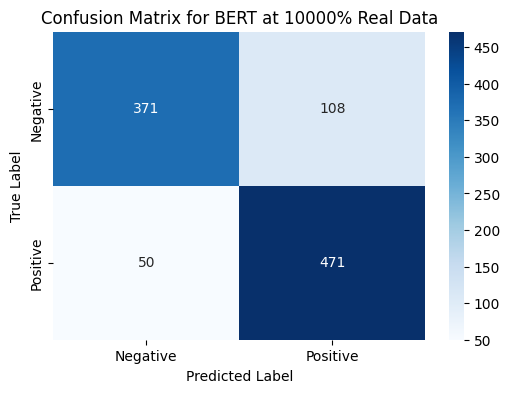

(0.842,
 0.8134715025906736,
 0.9040307101727447,
 0.8563636363636363,
 0.9218020588317792)

In [ ]:
print("\n--- BERT: 100% real data ---")
K.clear_session()
gc.collect()
tf.keras.backend.clear_session()

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(real_data, synthetic_data, real_ratio=1.0)
bert_tokenizer, bert_model_instance = get_new_bert_model_and_tokenizer()

train_dataset = prepare_dataset(bert_tokenizer, X_train, y_train)
val_dataset = prepare_dataset(bert_tokenizer, X_val, y_val)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

bert_model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

bert_model_instance.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

evaluate_model(bert_model_instance, test_encodings, y_test, model_type='bert', model_name='BERT', ratio=100)
